# Noise simulation and data generation

In the following sections we explain the simulation of errors and the data generation for the neural-network models.

## The lattice
The lattice class defined in hexagonal_lattice.py gives us a set of connected vertices and edges where the semion code is placed. Qubits occupy edges, and vertices and plaquettes are the stabilizers. The lattice has periodic boundaries, i.e., bottom and top and left and right borders are identified. We will now initialize and plot a small lattice of distance 4.

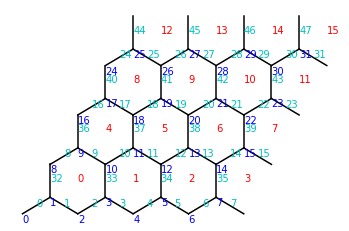

In [10]:
SRC_PATH = '../Python' # path to src

import numpy as np
import os
import sys
sys.path.append(os.path.abspath(SRC_PATH))

from hexagonal_lattice import HexagonalLattice
small_lattice = HexagonalLattice(4,4) 
small_lattice.plot_lattice(p_numbers=True, v_numbers=True, e_numbers=True)

Vertices are labeled in blue, plaquettes in red and edges in cyan. Since the lattice is periodic, we have that, for instance, vertex 0 is connected to edges \[0, 7, 44\] and vertex 24 to \[24, 31, 40\].

In [11]:
e0 = small_lattice.vertex2edge(0, both=False)
e1 = small_lattice.vertex2edge(24, both=False)
print(f'Vertex 0 -> {e0}, vertex 24 -> {e1}')

Vertex 0 -> [ 0  7 44], vertex 24 -> [24 31 40]


## Errors and pattern data
When a Z-Pauli error occurs on an edge, the syndrome measured at the two plaquettes of that edge flip. For an X error, the situation is more complex. The two vertices connected to the edge flip, but also some plaquettes may get excited. Which plaquettes are flipped when measured depends on a probability distribution, which is stored in the pattern directory.

Let's suppose an X error occurs in edge 37. First we identify which error pattern corresponds to this error. If instead of edge 37, the X error would have occurred in edge 38, we would get the same pattern, since it is the same error shifted to the right. 

In [12]:
import compute_pattern as cp
pattern37 = cp.x_error_pattern([37], small_lattice)
pattern38 = cp.x_error_pattern([38], small_lattice)
print(f'pattern [37] -> {pattern37}, pattern [38] -> {pattern38}')

pattern [37] -> [72], pattern [38] -> [72]


The same thing can be done for longer X error strings, such as two X errors on adjacent edges \[14, 39\].

In [13]:
pattern14_39 = cp.x_error_pattern([14, 39], small_lattice)
print(f'pattern [14, 39] -> {pattern14_39}')

pattern [14, 39] -> [ 0 72]


Once we have identified the pattern, we can get the probability distribution for plaquette excitations from previously saved pattern data or compute if it is not there. All this can be done with the function `plaquette_measurement`. Let's try for an X error in edge 37.

In [14]:
from error_model import plaquette_measurement
prob_dist, plaquette, _, _ = plaquette_measurement([37], small_lattice)
print('Probabilities: ',prob_dist)
print('Plaquettes: ',plaquette)

Probabilities:  [0.0625 0.     0.     0.0625 0.     0.0625 0.0625 0.     0.     0.5625
 0.0625 0.     0.0625 0.     0.     0.0625]
Plaquettes:  [4 1 8 5]


`plaquette_measurement` gives us the probability distribution `prob_dist` and the plaquettes affected `plaquette`, which are those around edge 37. The maximum probability is found for element 8, which corresponds to the following plaquette excitations:

In [15]:
d = np.argmax(prob_dist)
b = cp.de2bi(d, len(plaquette)) # decimal to binary
print('Excitation configuration: ', b)
p_excited = plaquette[np.squeeze(b).astype(bool)]
print('Plaquettes excited: ', p_excited)

Excitation configuration:  [[1 0 0 1]]
Plaquettes excited:  [4 5]


With a probability of 56.25% plaquettes 4 and 5 will be flipped, while the rest do not change.

Putting all this together, we can simulate Pauli noise on the code with the function `xyz_noise`. This function is given the probability of X, Y and Z errors and a lattice, and returns the X and Z errors that occurred and the syndrome measurement.

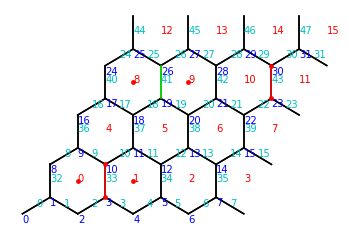

In [16]:
from error_model import xyz_noise
p_X = .02
p_Y = 0
p_Z = .02
X_edge, Z_edge, v_syn_ind, p_syn_ind = xyz_noise(
    p_X, p_Y, p_Z, small_lattice, plot=True, seed=12)

An X error in edge 33 (red) produces two plaquette excitations (plaquettes 0 and 1) plus the vertex excitations (vertex 3 and 10). Z error in edge 41 (green) produces plaquette excitations 8 and 9. X error in edge 43 produces two vertex excitations in 23 and 30 and no plaquette excitations.

## Decoding

The syndrome can be fed into a decoder, which, given the error syndrome, tries to predict the operations needed to recover the original state (annihilating the excitations). We will use here a simple decoder taking the excitations to vertex 0 and plaquette 0. This may be an unsuccesful recovery, and will produce a logical error which the neural network will try to predict.

In [17]:
from decoding import decoder_simple
# Recovery operators
X_recover, Z_recover = decoder_simple.decode(
    v_syn_ind, p_syn_ind, small_lattice)
# Logical error
logical_error = decoder_simple.decode_result(
    X_edge, Z_edge, v_syn_ind, p_syn_ind, small_lattice)
print(logical_error)

(array([False]), array([False]), array([False]), array([False]))


We see that for this particular case no logical error occurred.

## Training data generation

We can now use `xyz_noise` together with `decoder_simple` to simulate noise, produce error syndromes and obtain the logical errors of the simple decoder. Each training data example for our neural network $(x,y)$ will be composed by $x$ the syndromes and $y$ the logical error.

In [25]:
v_syn = np.zeros(small_lattice.N_vertex, dtype=bool)
v_syn[v_syn_ind] = True
p_syn = np.zeros(small_lattice.N_plaquette, dtype=bool)
p_syn[p_syn_ind] = True
x = np.concatenate([v_syn, p_syn])

y = decoder_simple.decode_result(
    X_edge, Z_edge, v_syn_ind, p_syn_ind, small_lattice)
y = np.squeeze(cp.bi2de(np.concatenate(y)))

print('Syndrome data: \n', x)
print('\nLogical error (16 categories): ', y)

Syndrome data: 
 [False False False  True False False False False False False  True False
 False False False False False False False False False False False  True
 False False False False False False  True False  True  True False False
 False False False False  True  True False False False False False False]

Logical error (16 categories):  0


Finally, we can generate and save training data with the function `data.main_data_gen`, which generates data files with $10^5$ examples each.